<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using plotting tools associated with the Landlab NetworkSedimentTransporter component 

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial illustrates how to plot the results of the NetworkSedimentTransporter Landlab component using the `plot_network_and_parcels` tool. 

In this example we will: 
- create a simple instance of the NetworkSedimentTransporter using a *synthetic river network
- create a simple instance of the NetworkSedimentTransporter using an *input shapefile for the river network
- show options for setting the color and line widths of network links
- show options for setting the color of parcels (marked as dots on the network)
- show options for setting the size of parcels
- show options for plotting a subset of the parcels
- demonstrate changing the timestep plotted
- show an example combining many plotting controls

First, import the necessary libraries:

In [1]:
import warnings

warnings.filterwarnings("ignore")
import os
import pathlib

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np
from landlab import ExampleData
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import plot_network_and_parcels
from landlab.io import read_shapefile


from matplotlib.colors import Normalize

## 1. Create and run the synthetic example of NST

First, we need to create an implementation of the Landlab NetworkModelGrid to plot. This example creates a synthetic grid, defining the location of each node and link. 

(array([  9.,  26.,  28.,  20.,  18.,  17.,  19.,   7.,  11.,   8.,  11.,
          4.,   6.,   1.,   1.,   5.,   2.,   0.,   1.,   2.,   4.,   6.,
          0.,   0.,   0.,   1.,   0.,   2.,   0.,   1.]),
 array([ 0.00852008,  0.01693062,  0.02534116,  0.0337517 ,  0.04216224,
         0.05057278,  0.05898333,  0.06739387,  0.07580441,  0.08421495,
         0.09262549,  0.10103603,  0.10944657,  0.11785712,  0.12626766,
         0.1346782 ,  0.14308874,  0.15149928,  0.15990982,  0.16832036,
         0.17673091,  0.18514145,  0.19355199,  0.20196253,  0.21037307,
         0.21878361,  0.22719415,  0.2356047 ,  0.24401524,  0.25242578,
         0.26083632]),
 <BarContainer object of 30 artists>)

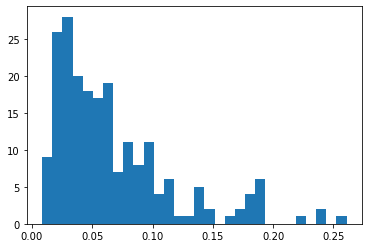

In [4]:
y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)

nodes_at_link = ((1, 0), (2, 1), (1, 7), (3, 1), (3, 4), (4, 5), (4, 6))

grid1 = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)
element_id = np.repeat(np.arange(grid1.number_of_links), 30)
element_id = np.expand_dims(element_id, axis=1)

volume = 0.1 * np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id))  # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id))  # (mass loss /m)

# Lognormal GSD
medianD = 0.05  # m
mu = np.log(medianD)
sigma = np.log(2)  # assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu, sigma, np.shape(element_id)
)  # (m) the diameter of grains in each parcel

plt.hist(D,bins=30)

In [5]:
y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)

nodes_at_link = ((1, 0), (2, 1), (1, 7), (3, 1), (3, 4), (4, 5), (4, 6))

grid1 = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)
grid1.at_node["bedrock__elevation"] = [0.0, 0.05, 0.2, 0.1, 0.25, 0.4, 0.8, 0.8]
grid1.at_node["topographic__elevation"] = [0.0, 0.05, 0.2, 0.1, 0.25, 0.4, 0.8, 0.8]
grid1.at_link["flow_depth"] = 2.5 * np.ones(grid1.number_of_links)  # m
grid1.at_link["reach_length"] = 200 * np.ones(grid1.number_of_links)  # m
grid1.at_link["channel_width"] = 1 * np.ones(grid1.number_of_links)  # m

# element_id is the link on which the parcel begins.
element_id = np.repeat(np.arange(grid1.number_of_links), 30)
element_id = np.expand_dims(element_id, axis=1)

volume = 0.1 * np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id))  # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id))  # (mass loss /m)

# Lognormal GSD
medianD = 0.05  # m
mu = np.log(medianD)
sigma = np.log(2)  # assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu, sigma, np.shape(element_id)
)  # (m) the diameter of grains in each parcel

time_arrival_in_link = np.random.rand(np.size(element_id), 1)
location_in_link = np.random.rand(np.size(element_id), 1)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume),
}

items = {"grid_element": "link", "element_id": element_id}

parcels1 = DataRecord(
    grid1,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

fd1 = FlowDirectorSteepest(grid1, "topographic__elevation")
fd1.run_one_step()

nst1 = NetworkSedimentTransporter(
    grid1,
    parcels1,
    fd1,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)
timesteps = 10  # total number of timesteps
dt = 60 * 60 * 24 * 1  # length of timestep (seconds)
for t in range(0, (timesteps * dt), dt):
    nst1.run_one_step(dt)

## 2. Create and run an example of NST using a shapefile to define the network

First, we need to create an implementation of the Landlab NetworkModelGrid to plot. This example creates a grid based on a polyline shapefile.  

In [6]:
datadir = ExampleData("io/shapefile", case="methow").base

shp_file = datadir / "MethowSubBasin.shp"
points_shapefile = datadir / "MethowSubBasin_Nodes_4.shp"

grid2 = read_shapefile(
    shp_file,
    points_shapefile=points_shapefile,
    node_fields=["usarea_km2", "Elev_m"],
    link_fields=["usarea_km2", "Length_m"],
    link_field_conversion={
        "usarea_km2": "drainage_area",
        "Slope": "channel_slope",
        "Length_m": "reach_length",
    },
    node_field_conversion={
        "usarea_km2": "drainage_area",
        "Elev_m": "topographic__elevation",
    },
    threshold=0.01,
)
grid2.at_node["bedrock__elevation"] = grid2.at_node["topographic__elevation"].copy()
grid2.at_link["channel_width"] = 1 * np.ones(grid2.number_of_links)
grid2.at_link["flow_depth"] = 0.9 * np.ones(grid2.number_of_links)

# element_id is the link on which the parcel begins.
element_id = np.repeat(np.arange(grid2.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1 * np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id))  # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id))  # (mass loss /m)

# Lognormal GSD
medianD = 0.15  # m
mu = np.log(medianD)
sigma = np.log(2)  # assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu, sigma, np.shape(element_id)
)  # (m) the diameter of grains in each parcel

time_arrival_in_link = np.random.rand(np.size(element_id), 1)
location_in_link = np.random.rand(np.size(element_id), 1)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume),
}

items = {"grid_element": "link", "element_id": element_id}

parcels2 = DataRecord(
    grid2,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

fd2 = FlowDirectorSteepest(grid2, "topographic__elevation")
fd2.run_one_step()

nst2 = NetworkSedimentTransporter(
    grid2,
    parcels2,
    fd2,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

for t in range(0, (timesteps * dt), dt):
    nst2.run_one_step(dt)

## 3. Options for link color and link line widths

The dictionary below (`link_color_options`) outlines 4 examples of link color and line width choices: 
1. The default output of `plot_network_and_parcels`
2. Some simple modifications: the whole network is red, with a line width of 7, and no parcels.
3. Coloring links by an existing grid link attribute, in this case the total volume of sediment on the link (`grid.at_link.["sediment_total_volume"]`, which is created by the `NetworkSedimentTransporter`)
4. Similar to #3 above, but taking advantange of additional flexiblity in plotting

In [7]:
network_norm = Normalize(-1, 6)  # see matplotlib.colors.Normalize

link_color_options = [
    {},  # empty dictionary = defaults
    {
        "network_color": "r",  # specify some simple modifications.
        "network_linewidth": 7,
        "parcel_alpha": 0,  # make parcels transparent (not visible)
    },
    {
        "link_attribute": "sediment_total_volume",  # color links by an existing grid link attribute
        "parcel_alpha": 0,
    },
    {
        "link_attribute": "sediment_total_volume",
        "network_norm": network_norm,  # and normalize color scheme
        "link_attribute_title": "Total Sediment Volume",  # title on link color legend
        "parcel_alpha": 0,
        "network_linewidth": 3,
    },
]

Below, we implement these 4 plotting options, first for the synthetic network, and then for the shapefile-delineated network:

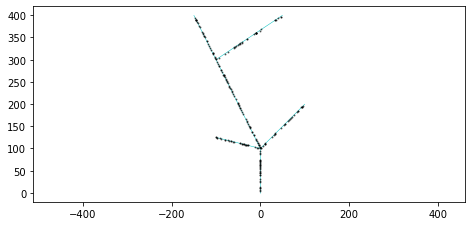

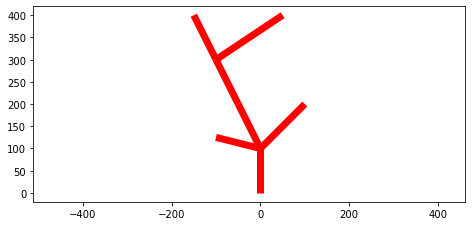

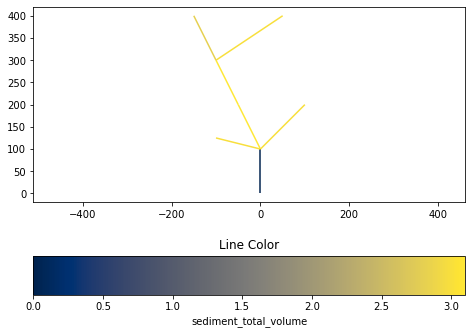

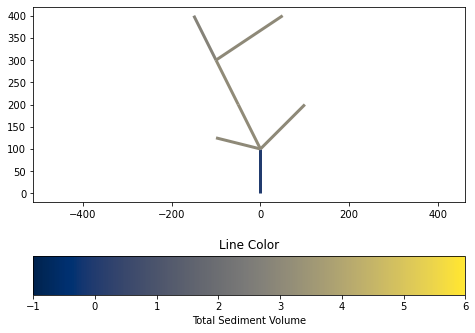

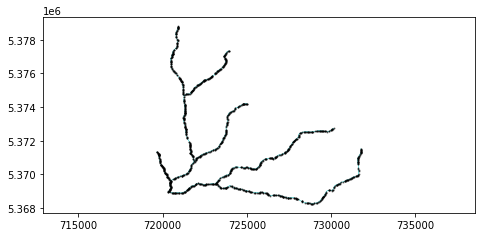

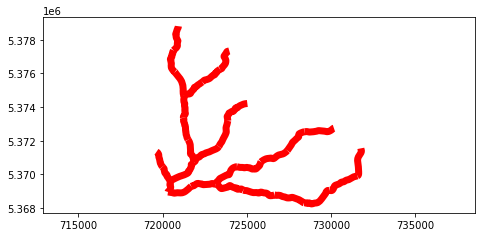

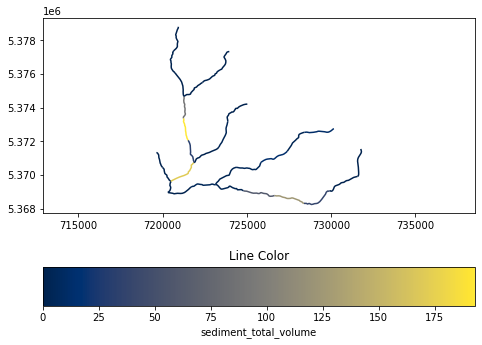

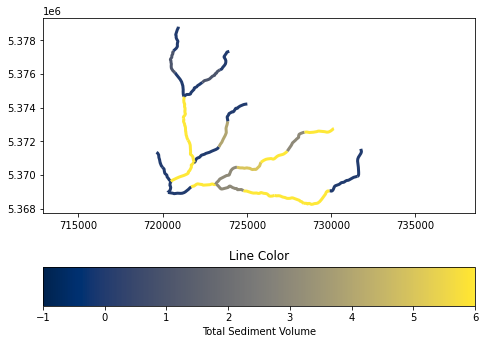

In [8]:
for grid, parcels in zip([grid1, grid2], [parcels1, parcels2]):
    for l_opts in link_color_options:
        fig = plot_network_and_parcels(grid, parcels, parcel_time_index=0, **l_opts)
        plt.show()

In addition to plotting link coloring using an existing link attribute, we can pass any array of size link. In this example, we color links using an array of random values. 

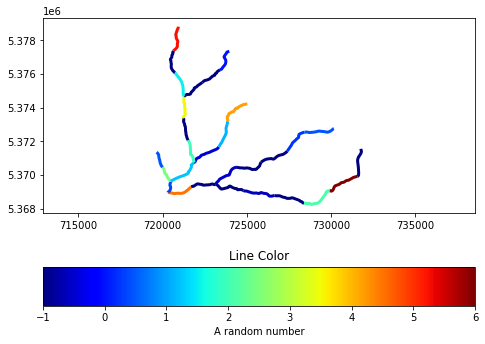

In [16]:
random_link = np.random.randn(grid2.size("link"))*3

l_opts = {
    "link_attribute": random_link,  # use an array of size link
    "network_cmap": "jet",  # change colormap
    "network_norm": network_norm,  # and normalize
    "link_attribute_title": "A random number",
    "parcel_alpha": 0,
    "network_linewidth": 3,
}
fig = plot_network_and_parcels(grid2, parcels2, parcel_time_index=0, **l_opts)
plt.show()

## 4. Options for parcel color

The dictionary below (`parcel_color_options`) outlines 4 examples of link color and line width choices: 
1. The default output of `plot_network_and_parcels`
2. Some simple modifications: all parcels are red, with a parcel size of 10
3. Color parcels by an existing parcel attribute, in this case the sediment diameter of the parcel (`parcels1.dataset['D']`)
4. Color parcels by an existing parcel attribute, but change the colormap. 

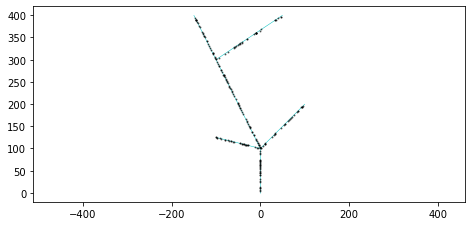

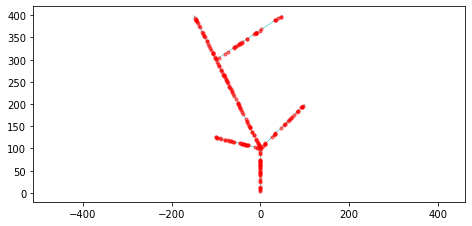

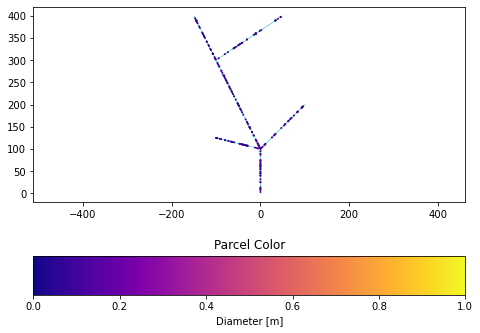

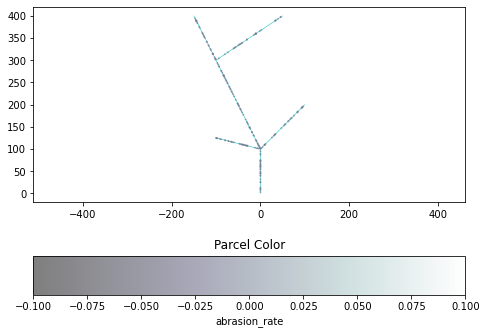

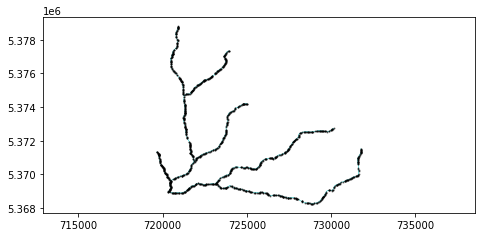

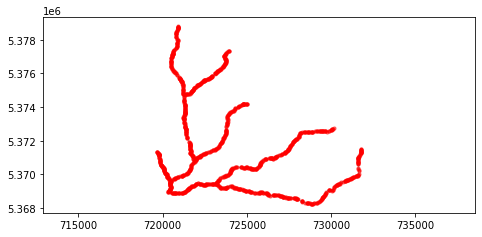

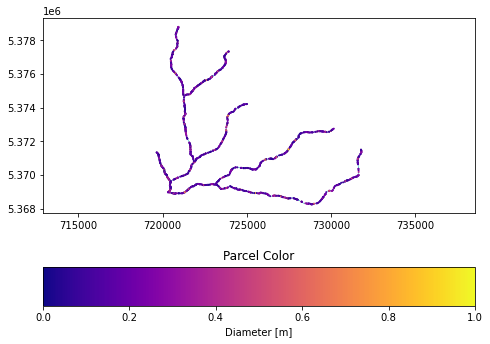

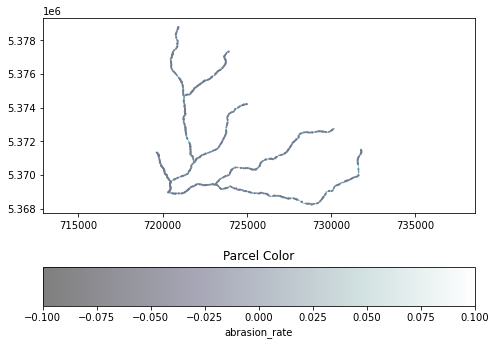

In [9]:
parcel_color_norm = Normalize(0, 1)  # Linear normalization
parcel_color_norm2 = colors.LogNorm(vmin=0.01, vmax=1)

parcel_color_options = [
    {},  # empty dictionary = defaults
    {"parcel_color": "r", "parcel_size": 10},  # specify some simple modifications.
    {
        "parcel_color_attribute": "D",  # existing parcel attribute.
        "parcel_color_norm": parcel_color_norm,
        "parcel_color_attribute_title": "Diameter [m]",
        "parcel_alpha": 1.0,
    },
    {
        "parcel_color_attribute": "abrasion_rate",  # silly example, does not vary in our example
        "parcel_color_cmap": "bone",
    },
]

for grid, parcels in zip([grid1, grid2], [parcels1, parcels2]):
    for pc_opts in parcel_color_options:
        fig = plot_network_and_parcels(grid, parcels, parcel_time_index=0, **pc_opts)
        plt.show()

## 5. Options for parcel size
The dictionary below (`parcel_size_options`) outlines 4 examples of link color and line width choices: 
1. The default output of `plot_network_and_parcels`
2. Set a uniform parcel size and color
3. Size parcels by an existing parcel attribute, in this case the sediment diameter (`parcels1.dataset['D']`), and making the parcel markers entirely opaque. 
4. Normalize parcel size on a logarithmic scale, and change the default maximum and minimum parcel sizes. 

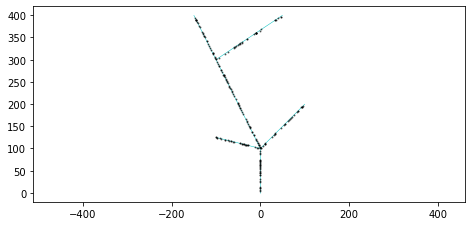

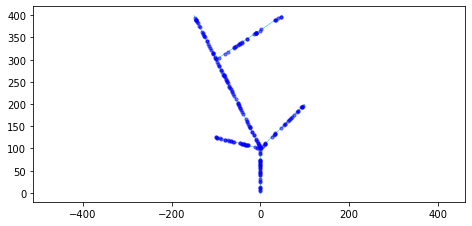

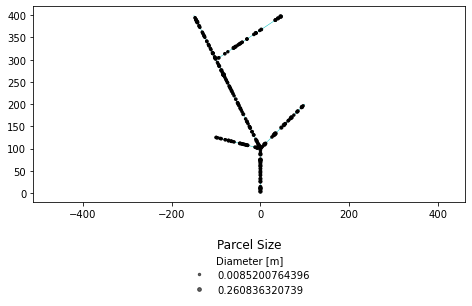

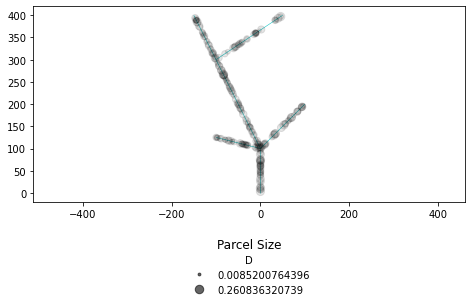

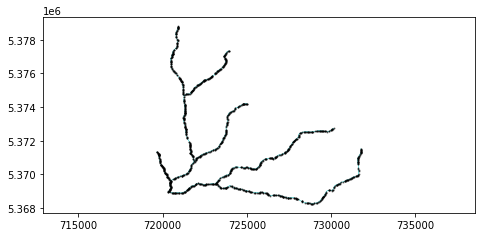

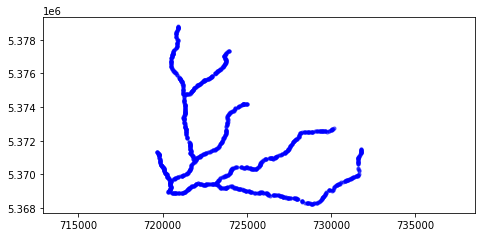

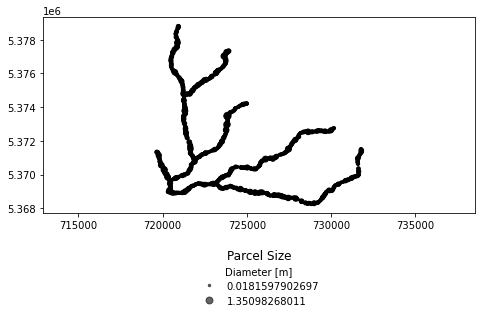

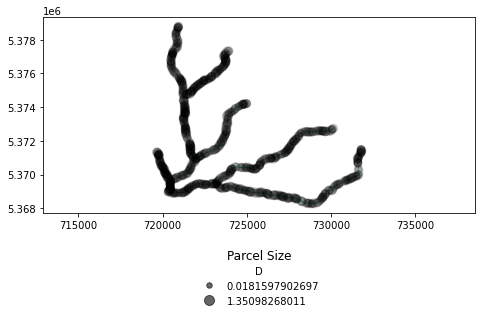

In [10]:
parcel_size_norm = Normalize(0, 1)
parcel_size_norm2 = colors.LogNorm(vmin=0.01, vmax=1)

parcel_size_options = [
    {},  # empty dictionary = defaults
    {"parcel_color": "b", "parcel_size": 10},  # specify some simple modifications.
    {
        "parcel_size_attribute": "D",  # use a parcel attribute.
        "parcel_size_norm": parcel_color_norm,
        "parcel_size_attribute_title": "Diameter [m]",
        "parcel_alpha": 1.0,  # default parcel_alpha = 0.5
    },
    {
        "parcel_size_attribute": "D",
        "parcel_size_norm": parcel_size_norm2,
        "parcel_size_min": 10,  # default = 5
        "parcel_size_max": 100,  # default = 40
        "parcel_alpha": 0.1,
    },
]

for grid, parcels in zip([grid1, grid2], [parcels1, parcels2]):
    for ps_opts in parcel_size_options:
        fig = plot_network_and_parcels(grid, parcels, parcel_time_index=0, **ps_opts)
        plt.show()

## 6. Plotting a subset of the parcels

In some cases, we might want to plot only a subset of the parcels on the network. Below, we plot every 50th parcel in the `DataRecord`. 

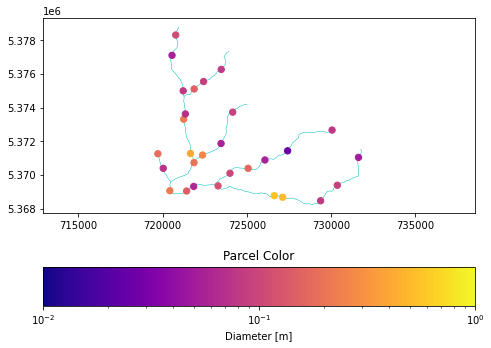

In [11]:
parcel_filter = np.zeros((parcels2.dataset.dims["item_id"]), dtype=bool)
parcel_filter[::50] = True
pc_opts = {
    "parcel_color_attribute": "D",  # a more complex normalization and a parcel filter.
    "parcel_color_norm": parcel_color_norm2,
    "parcel_color_attribute_title": "Diameter [m]",
    "parcel_alpha": 1.0,
    "parcel_size": 40,
    "parcel_filter": parcel_filter,
}
fig = plot_network_and_parcels(grid2, parcels2, parcel_time_index=0, **pc_opts)
plt.show()

## 7. Select the parcel timestep to be plotted

As a default, `plot_network_and_parcels` plots parcel positions for the last timestep of the model run. However, `NetworkSedimentTransporter` tracks the motion of parcels for all timesteps. We can plot the location of parcels on the link at any timestep using `parcel_time_index`. 

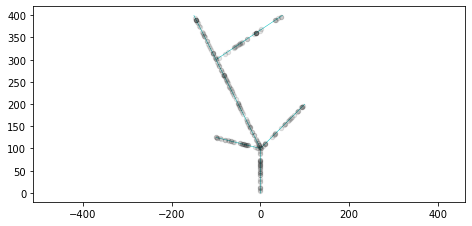

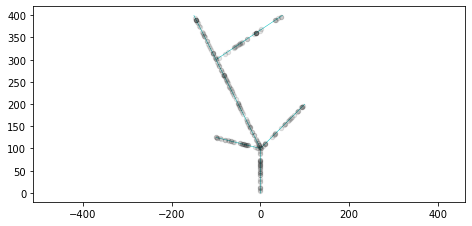

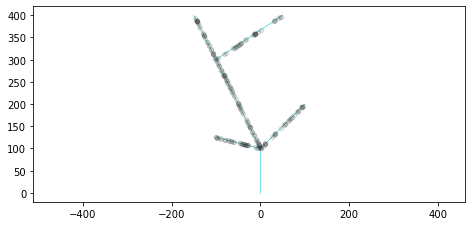

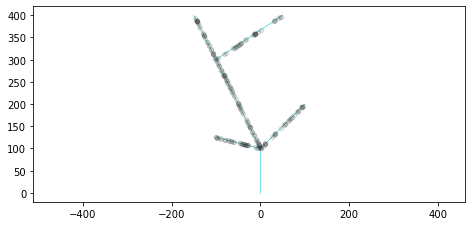

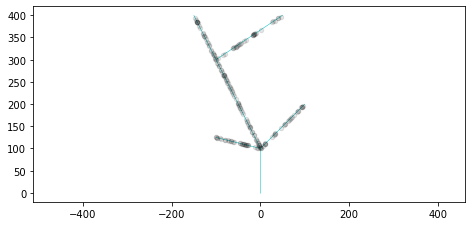

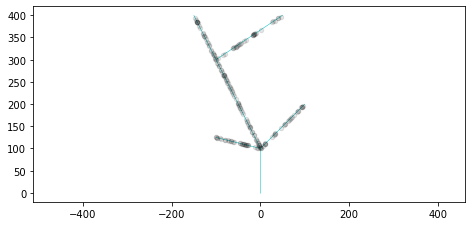

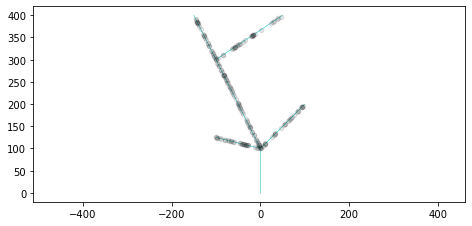

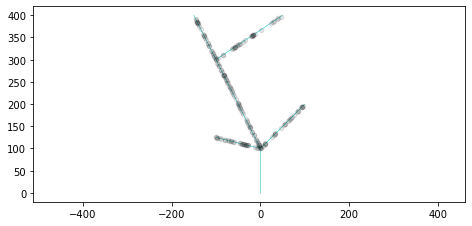

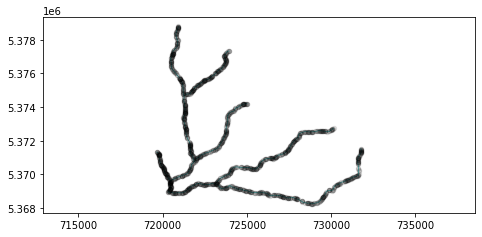

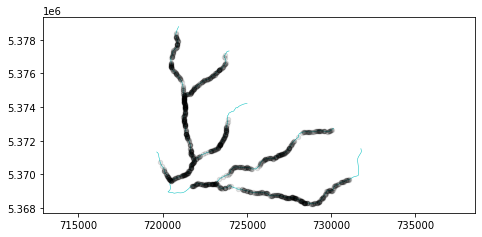

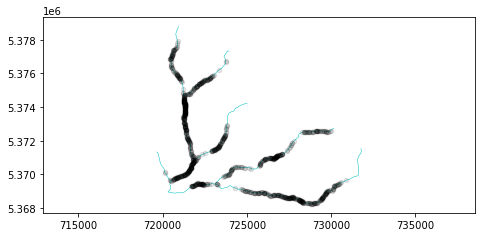

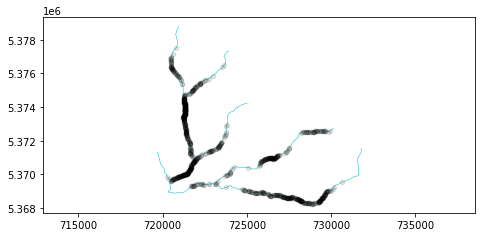

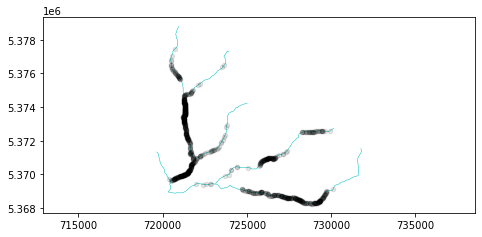

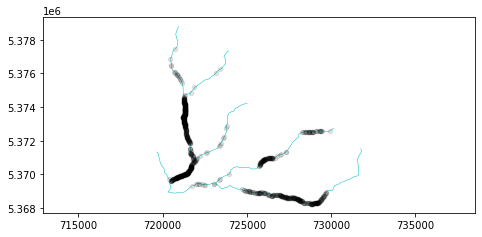

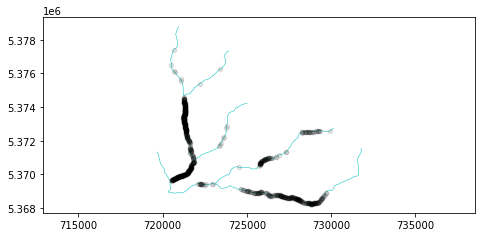

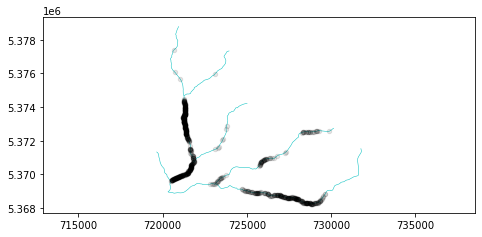

In [12]:
parcel_time_options = [0,1,2,3,4,5,6,7]

for grid, parcels in zip([grid1, grid2], [parcels1, parcels2]):
    for pt_opts in parcel_time_options:
        fig = plot_network_and_parcels(
            grid, parcels, parcel_size=20, parcel_alpha=0.1, parcel_time_index=pt_opts
        )
        plt.show()

## 7. Combining network and parcel plotting options

Nothing will stop us from making all of the choices at once. 

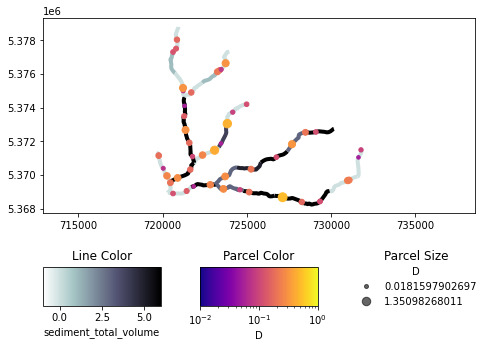

In [22]:
parcel_color_norm = colors.LogNorm(vmin=0.01, vmax=1)

parcel_filter = np.zeros((parcels2.dataset.dims["item_id"]), dtype=bool)
parcel_filter[::30] = True

fig = plot_network_and_parcels(
    grid2,
    parcels2,
    parcel_time_index=0,
    parcel_filter=parcel_filter,
    link_attribute="sediment_total_volume",
    network_norm=network_norm,
    network_linewidth=4,
    network_cmap="bone_r",
    parcel_alpha=1.0,
    parcel_color_attribute="D",
    parcel_color_norm=parcel_color_norm2,
    parcel_size_attribute="D",
    parcel_size_min=5,
    parcel_size_max=150,
    parcel_size_norm=parcel_size_norm,
    parcel_size_attribute_title="D",
)